
# Random Forest: Predicting Premier League Home Wins (2015–2025)

**Project:** DATA1002 — Ten Years of the Premier League  
**Goal:** Predict whether the **home team wins (1)** or **does not win (0)** using pre‑match features such as Elo and xG.

This notebook:
- Loads the integrated dataset (`PL_integrated_dataset_10years.csv`).
- Engineers a binary target (`HomeWin`).
- Trains a **Random Forest** classifier.
- Evaluates accuracy, precision/recall, and shows a confusion matrix.
- Displays feature importances.
- (Optional) Performs hyperparameter tuning via `GridSearchCV`.


In [18]:
# ==============================
# 1. Imports
# ==============================
import os
import pandas as pd
import numpy as np
from pathlib import Path

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Plotting (matplotlib only)
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
print('Libraries loaded.')


Libraries loaded.


In [19]:
# ==============================
# 2. Load Data
# ==============================
# Try a few sensible locations relative to this notebook and project root.
default_paths = [
    'PL_integrated_dataset_10years.csv',
    '../PL_integrated_dataset_10years.csv',
    'data/processed/PL_integrated_dataset_10years.csv',
    '../data/processed/PL_integrated_dataset_10years.csv',
    '../../data/processed/PL_integrated_dataset_10years.csv'
]

# Also attempt to find the file by walking up parent directories (helps when the notebook's CWD is project root or different).
csv_path = None

# First check the simple candidates
for candidate in default_paths:
    p = Path(candidate)
    if p.exists():
        csv_path = p.resolve()
        break

# If not found yet, walk parents from the current working directory and look for data/processed/...
if csv_path is None:
    cwd = Path.cwd()
    for parent in [cwd] + list(cwd.parents):
        candidate = parent / 'data' / 'processed' / 'PL_integrated_dataset_10years.csv'
        if candidate.exists():
            csv_path = candidate.resolve()
            break

if csv_path is None:
    raise FileNotFoundError(
        'Could not find PL_integrated_dataset_10years.csv. Tried common relative paths '
        'and parent/data/processed locations. Make sure the file exists in the project `data/processed/` folder.'
    )

# Load with pandas (convert Path to str for compatibility).
df = pd.read_csv(str(csv_path))
print('Loaded:', csv_path)
print('Shape:', df.shape)
df.head()


Loaded: /Users/cuongtrantrong/Documents/study/usyd/Y3/DATA1002/Assingment/DATA1002/data/processed/PL_integrated_dataset_10years.csv
Shape: (3774, 63)


,AC,AF,AR,AS,AST,AY,AwayTeam,B365A,B365D,B365H,BWA,BWD,BWH,Date,Div,FTAG,FTHG,FTR,HC,HF,HR,HS,HST,HTAG,HTHG,HTR,HY,HomeTeam,PSA,PSCA,PSCD,PSCH,PSD,PSH,Referee,Season,WHA,WHD,WHH,TotalGoals,GoalDifference_Home,GoalDifference_Away,HomePoints,AwayPoints,HomeShotAccuracy,AwayShotAccuracy,MatchWeek,DayOfWeek,Month,Year,Home_xG,Away_xG,Total_xG,xG_Difference,Home_ELO,Away_ELO,ELO_Difference,Home_Goals_vs_xG,Away_Goals_vs_xG,ELO_Predicted_Winner,ELO_Prediction_Correct,xG_Predicted_Winner,xG_Prediction_Correct
0,3,13,0,7,3,4,Aston Villa,4.00,3.6,2.00,3.70,3.30,2.00,2015-08-08,E0,1,0,A,6,13,0,11,2,0,0,D,3,Bournemouth,4.27,4.70,3.88,1.82,3.65,1.95,M Clattenburg,2015-2016,4.0,3.5,1.91,1,-1,1,0,3,0.181818,0.428571,1,Saturday,8,2015,0.876106,0.782253,1.658359,0.093853,1594.601929,1577.901123,16.700806,-0.876106,0.217747,H,False,H,False
1,8,16,0,18,10,3,Swansea City,11.00,5.0,1.36,9.00,4.75,1.40,2015-08-08,E0,2,2,D,4,15,1,11,3,1,2,H,1,Chelsea,10.39,10.88,5.04,1.37,4.92,1.39,M Oliver,2015-2016,10.0,4.0,1.40,4,0,0,1,1,0.272727,0.555556,1,Saturday,8,2015,0.643960,2.592030,3.235990,-1.948070,1890.962891,1670.608276,220.354614,1.356040,-0.592030,H,False,A,False
2,2,13,0,11,5,2,Watford,5.50,3.9,1.70,5.00,3.50,1.70,2015-08-08,E0,2,2,D,8,7,0,10,5,1,0,A,1,Everton,5.62,5.44,3.76,1.75,3.95,1.70,M Jones,2015-2016,5.0,3.5,1.73,4,0,0,1,1,0.500000,0.454545,1,Saturday,8,2015,0.604226,0.557892,1.162118,0.046334,1706.561157,1574.087280,132.473877,1.395774,1.442108,H,False,H,False
3,3,17,0,10,5,4,Sunderland,4.33,3.5,1.95,3.75,3.30,2.00,2015-08-08,E0,2,4,H,6,13,0,19,8,0,3,H,2,Leicester City,4.34,5.10,3.74,1.79,3.48,1.99,L Mason,2015-2016,2.7,3.1,2.00,6,2,-2,3,0,0.421053,0.500000,1,Saturday,8,2015,2.568030,1.459460,4.027490,1.108570,1633.624390,1605.132446,28.491943,1.431970,0.540540,H,True,H,True
4,2,12,0,9,4,3,Tottenham,6.00,4.0,1.65,5.50,4.00,1.65,2015-08-08,E0,0,1,H,1,12,0,9,1,0,1,H,2,Manchester United,5.90,6.04,4.07,1.64,4.09,1.65,J Moss,2015-2016,6.0,3.6,1.62,1,1,-1,3,0,0.111111,0.444444,1,Saturday,8,2015,0.627539,0.674600,1.302139,-0.047061,1810.338257,1730.680176,79.658081,0.372461,-0.674600,H,True,A,False


In [20]:
# ==============================
# 3. Quick Sanity Checks
# ==============================
print('Columns available:')
print(sorted(df.columns.tolist()))

# Create binary target for a home win (1) vs anything else (0). Ensure integer dtype.
if 'FTR' not in df.columns:
    raise ValueError('Column FTR (full-time result) is missing. Please check the dataset source.')

df['HomeWin'] = np.where(df['FTR'] == 'H', 1, 0).astype(int)
print('HomeWin distribution:')
print(df['HomeWin'].value_counts(dropna=False))
print('\nMissing values per column:')
print(df.isnull().sum())


Columns available:
['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'AwayPoints', 'AwayShotAccuracy', 'AwayTeam', 'Away_ELO', 'Away_Goals_vs_xG', 'Away_xG', 'B365A', 'B365D', 'B365H', 'BWA', 'BWD', 'BWH', 'Date', 'DayOfWeek', 'Div', 'ELO_Difference', 'ELO_Predicted_Winner', 'ELO_Prediction_Correct', 'FTAG', 'FTHG', 'FTR', 'GoalDifference_Away', 'GoalDifference_Home', 'HC', 'HF', 'HR', 'HS', 'HST', 'HTAG', 'HTHG', 'HTR', 'HY', 'HomePoints', 'HomeShotAccuracy', 'HomeTeam', 'Home_ELO', 'Home_Goals_vs_xG', 'Home_xG', 'MatchWeek', 'Month', 'PSA', 'PSCA', 'PSCD', 'PSCH', 'PSD', 'PSH', 'Referee', 'Season', 'TotalGoals', 'Total_xG', 'WHA', 'WHD', 'WHH', 'Year', 'xG_Difference', 'xG_Predicted_Winner', 'xG_Prediction_Correct']
HomeWin distribution:
HomeWin
0    2098
1    1676
Name: count, dtype: int64

Missing values per column:
AC                        0
AF                        0
AR                        0
AS                        0
AST                       0
                         ..
ELO_Predicte


## Feature Engineering Notes

The next cell computes **trailing-5 match statistics** for each team. Key points:

1. **Per-team rolling averages**: For each team, we compute their average performance over their last 5 matches (regardless of home/away venue)
2. **No data leakage**: We use `.shift()` before `.rolling()` to ensure the current match is NOT included in the trailing statistics
3. **Features computed**:
   - Points (0/1/3 per match)
   - Goals for/against and goal differential
   - xG (expected goals)
   - Shot accuracy
   - Win rate (points/3)
4. **Mapping**: Each match row gets the home team's trailing stats in `Home_*_last5` columns and the away team's trailing stats in `Away_*_last5` columns


In [21]:
# ==============================
# 4. Feature Engineering (pre-match only)
# ==============================
# Sort chronologically so rolling features respect time.
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Season', 'Date']).reset_index(drop=True)

# Ensure we have per-match points columns (some sources already include these).
if 'HomePoints' in df.columns and 'AwayPoints' in df.columns:
    df['HomeMatchPoints'] = df['HomePoints']
    df['AwayMatchPoints'] = df['AwayPoints']
else:
    home_points_map = {'H': 3, 'D': 1, 'A': 0}
    away_points_map = {'H': 0, 'D': 1, 'A': 3}
    df['HomeMatchPoints'] = df['FTR'].map(home_points_map)
    df['AwayMatchPoints'] = df['FTR'].map(away_points_map)

# We'll compute trailing-5 (overall, across home+away matches) for each team and then
# map the team's trailing stats to both home and away match rows.
window = 5

# Build a per-team match log (one row per team per match) combining home and away perspectives.
home_records = []
away_records = []

for idx, row in df.iterrows():
    # Home team record for this match
    home_records.append({
        'Date': row['Date'],
        'Season': row['Season'],
        'Team': row['HomeTeam'],
        'MatchPoints': row['HomeMatchPoints'],
        'GoalsFor': row['FTHG'],
        'GoalsAgainst': row['FTAG'],
        'xG': row.get('Home_xG', np.nan),
        'ShotAccuracy': row.get('HomeShotAccuracy', np.nan),
        'original_idx': idx
    })
    # Away team record for this match
    away_records.append({
        'Date': row['Date'],
        'Season': row['Season'],
        'Team': row['AwayTeam'],
        'MatchPoints': row['AwayMatchPoints'],
        'GoalsFor': row['FTAG'],
        'GoalsAgainst': row['FTHG'],
        'xG': row.get('Away_xG', np.nan),
        'ShotAccuracy': row.get('AwayShotAccuracy', np.nan),
        'original_idx': idx
    })

# Combine into one dataframe and sort chronologically by team
team_matches = pd.DataFrame(home_records + away_records)
team_matches = team_matches.sort_values(['Team', 'Season', 'Date']).reset_index(drop=True)

# Ensure numeric types for rolling computations
for col in ['MatchPoints', 'GoalsFor', 'GoalsAgainst', 'xG', 'ShotAccuracy']:
    team_matches[col] = pd.to_numeric(team_matches[col], errors='coerce')

# Compute trailing-5 statistics for each team (shift to avoid using current match)
grp = team_matches.groupby('Team')
team_matches['points_last5'] = grp['MatchPoints'].transform(
    lambda s: s.shift().rolling(window, min_periods=1).mean()
)
team_matches['goals_for_last5'] = grp['GoalsFor'].transform(
    lambda s: s.shift().rolling(window, min_periods=1).mean()
)
team_matches['goals_against_last5'] = grp['GoalsAgainst'].transform(
    lambda s: s.shift().rolling(window, min_periods=1).mean()
)
team_matches['goal_diff_last5'] = (
    team_matches['goals_for_last5'] - team_matches['goals_against_last5']
)
team_matches['xG_last5'] = grp['xG'].transform(
    lambda s: s.shift().rolling(window, min_periods=1).mean()
)
team_matches['shot_accuracy_last5'] = grp['ShotAccuracy'].transform(
    lambda s: s.shift().rolling(window, min_periods=1).mean()
)
team_matches['win_rate_last5'] = team_matches['points_last5'] / 3.0

# Now we need to map these team-level stats back to the original df
# For each match, we lookup the home team's stats and away team's stats
trailing_cols = [
    'points_last5', 'goals_for_last5', 'goals_against_last5', 
    'goal_diff_last5', 'xG_last5', 'shot_accuracy_last5', 'win_rate_last5'
]

# Create a lookup dictionary: (team, date, season) -> trailing stats
team_stats_lookup = team_matches.set_index(['Team', 'Season', 'Date'])[trailing_cols].to_dict('index')

# Map to home and away sides
for col in trailing_cols:
    home_col = f'Home_{col}'
    away_col = f'Away_{col}'
    
    df[home_col] = df.apply(
        lambda row: team_stats_lookup.get(
            (row['HomeTeam'], row['Season'], row['Date']), {}
        ).get(col, np.nan),
        axis=1
    )
    df[away_col] = df.apply(
        lambda row: team_stats_lookup.get(
            (row['AwayTeam'], row['Season'], row['Date']), {}
        ).get(col, np.nan),
        axis=1
    )

# Early-season matches have fewer than five games of history; fill with zeros for modeling convenience.
rolling_cols = [
    'Home_points_last5', 'Away_points_last5',
    'Home_goals_for_last5', 'Away_goals_for_last5',
    'Home_goals_against_last5', 'Away_goals_against_last5',
    'Home_goal_diff_last5', 'Away_goal_diff_last5',
    'Home_xG_last5', 'Away_xG_last5',
    'Home_shot_accuracy_last5', 'Away_shot_accuracy_last5',
    'Home_win_rate_last5', 'Away_win_rate_last5'
]
df[rolling_cols] = df[rolling_cols].fillna(0.0)

# Drop temporary helper columns (but keep any original HomePoints/AwayPoints if they existed).
df = df.drop(columns=[c for c in ['HomeMatchPoints', 'AwayMatchPoints'] if c in df.columns])
print(f'Feature engineering complete. Added {len(rolling_cols)} trailing-5 features.')
df.head()


Feature engineering complete. Added 14 trailing-5 features.


,AC,AF,AR,AS,AST,AY,AwayTeam,B365A,B365D,B365H,BWA,BWD,BWH,Date,Div,FTAG,FTHG,FTR,HC,HF,HR,HS,HST,HTAG,HTHG,HTR,HY,HomeTeam,PSA,PSCA,PSCD,PSCH,PSD,PSH,Referee,Season,WHA,WHD,WHH,TotalGoals,GoalDifference_Home,GoalDifference_Away,HomePoints,AwayPoints,HomeShotAccuracy,AwayShotAccuracy,MatchWeek,DayOfWeek,Month,Year,Home_xG,Away_xG,Total_xG,xG_Difference,Home_ELO,Away_ELO,ELO_Difference,Home_Goals_vs_xG,Away_Goals_vs_xG,ELO_Predicted_Winner,ELO_Prediction_Correct,xG_Predicted_Winner,xG_Prediction_Correct,HomeWin,Home_points_last5,Away_points_last5,Home_goals_for_last5,Away_goals_for_last5,Home_goals_against_last5,Away_goals_against_last5,Home_goal_diff_last5,Away_goal_diff_last5,Home_xG_last5,Away_xG_last5,Home_shot_accuracy_last5,Away_shot_accuracy_last5,Home_win_rate_last5,Away_win_rate_last5
0,3,13,0,7,3,4,Aston Villa,4.00,3.6,2.00,3.70,3.30,2.00,2015-08-08,E0,1,0,A,6,13,0,11,2,0,0,D,3,Bournemouth,4.27,4.70,3.88,1.82,3.65,1.95,M Clattenburg,2015-2016,4.0,3.5,1.91,1,-1,1,0,3,0.181818,0.428571,1,Saturday,8,2015,0.876106,0.782253,1.658359,0.093853,1594.601929,1577.901123,16.700806,-0.876106,0.217747,H,False,H,False,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8,16,0,18,10,3,Swansea City,11.00,5.0,1.36,9.00,4.75,1.40,2015-08-08,E0,2,2,D,4,15,1,11,3,1,2,H,1,Chelsea,10.39,10.88,5.04,1.37,4.92,1.39,M Oliver,2015-2016,10.0,4.0,1.40,4,0,0,1,1,0.272727,0.555556,1,Saturday,8,2015,0.643960,2.592030,3.235990,-1.948070,1890.962891,1670.608276,220.354614,1.356040,-0.592030,H,False,A,False,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,13,0,11,5,2,Watford,5.50,3.9,1.70,5.00,3.50,1.70,2015-08-08,E0,2,2,D,8,7,0,10,5,1,0,A,1,Everton,5.62,5.44,3.76,1.75,3.95,1.70,M Jones,2015-2016,5.0,3.5,1.73,4,0,0,1,1,0.500000,0.454545,1,Saturday,8,2015,0.604226,0.557892,1.162118,0.046334,1706.561157,1574.087280,132.473877,1.395774,1.442108,H,False,H,False,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,17,0,10,5,4,Sunderland,4.33,3.5,1.95,3.75,3.30,2.00,2015-08-08,E0,2,4,H,6,13,0,19,8,0,3,H,2,Leicester City,4.34,5.10,3.74,1.79,3.48,1.99,L Mason,2015-2016,2.7,3.1,2.00,6,2,-2,3,0,0.421053,0.500000,1,Saturday,8,2015,2.568030,1.459460,4.027490,1.108570,1633.624390,1605.132446,28.491943,1.431970,0.540540,H,True,H,True,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,12,0,9,4,3,Tottenham,6.00,4.0,1.65,5.50,4.00,1.65,2015-08-08,E0,0,1,H,1,12,0,9,1,0,1,H,2,Manchester United,5.90,6.04,4.07,1.64,4.09,1.65,J Moss,2015-2016,6.0,3.6,1.62,1,1,-1,3,0,0.111111,0.444444,1,Saturday,8,2015,0.627539,0.674600,1.302139,-0.047061,1810.338257,1730.680176,79.658081,0.372461,-0.674600,H,True,A,False,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# ==============================
# 4.5 Verify Trailing-5 Features
# ==============================
# Quick diagnostic to ensure trailing features were computed correctly
last5_cols = [c for c in df.columns if c.endswith('_last5')]
print(f'Found {len(last5_cols)} trailing-5 columns:', last5_cols[:5], '...')

if last5_cols:
    # Check for non-zero values (should have many after first 5 matches per team)
    nonzero_counts = (df[last5_cols] != 0).sum()
    print(f'\nNon-zero counts per trailing column (showing first 5):')
    print(nonzero_counts.head())
    
    # Show a sample of matches with their trailing features (skip first few rows which will be zeros)
    print('\nSample of trailing features (rows 20-25 to skip early-season zeros):')
    sample_cols = ['Date', 'HomeTeam', 'AwayTeam', 'Home_points_last5', 'Away_points_last5', 
                   'Home_xG_last5', 'Away_xG_last5', 'Home_goals_for_last5', 'Away_goals_for_last5']
    display(df[sample_cols].iloc[20:25])
    
    # Show summary statistics
    print(f'\nSummary statistics for trailing features:')
    display(df[last5_cols].describe())


Found 14 trailing-5 columns: ['Home_points_last5', 'Away_points_last5', 'Home_goals_for_last5', 'Away_goals_for_last5', 'Home_goals_against_last5'] ...

Non-zero counts per trailing column (showing first 5):
Home_points_last5           3673
Away_points_last5           3695
Home_goals_for_last5        3738
Away_goals_for_last5        3736
Home_goals_against_last5    3740
dtype: int64

Sample of trailing features (rows 20-25 to skip early-season zeros):


,Date,HomeTeam,AwayTeam,Home_points_last5,Away_points_last5,Home_xG_last5,Away_xG_last5,Home_goals_for_last5,Away_goals_for_last5
20,2015-08-22,Crystal Palace,Aston Villa,1.5,1.5,1.536942,0.500686,2.0,0.5
21,2015-08-22,Leicester City,Tottenham,3.0,0.5,2.188710,1.190370,3.0,1.0
22,2015-08-22,Manchester United,Newcastle United,3.0,0.5,0.643971,0.829619,1.0,1.0
23,2015-08-22,Norwich City,Stoke City,1.5,0.5,1.423810,1.595417,2.0,1.0
24,2015-08-22,Sunderland,Swansea City,0.0,2.0,0.894294,2.283135,1.5,2.0



Summary statistics for trailing features:


,Home_points_last5,Away_points_last5,Home_goals_for_last5,Away_goals_for_last5,Home_goals_against_last5,Away_goals_against_last5,Home_goal_diff_last5,Away_goal_diff_last5,Home_xG_last5,Away_xG_last5,Home_shot_accuracy_last5,Away_shot_accuracy_last5,Home_win_rate_last5,Away_win_rate_last5
count,3774.000000,3774.000000,3774.000000,3774.000000,3774.000000,3774.000000,3774.000000,3774.000000,3774.000000,3774.000000,3774.000000,3774.000000,3774.000000,3774.000000
mean,1.359345,1.402663,1.398211,1.426122,1.417894,1.392024,-0.019683,0.034097,1.409704,1.438799,0.350208,0.349888,0.453115,0.467554
std,0.714194,0.708800,0.695947,0.691385,0.644501,0.634881,1.064177,1.054866,0.533072,0.538082,0.079815,0.078373,0.238065,0.236267
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.600000,-3.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.800000,0.800000,0.800000,1.000000,1.000000,1.000000,-0.800000,-0.600000,1.020461,1.052216,0.300241,0.297633,0.266667,0.266667
50%,1.400000,1.400000,1.366667,1.400000,1.400000,1.400000,0.000000,0.000000,1.341215,1.361653,0.348823,0.349704,0.466667,0.466667
75%,1.800000,2.000000,1.800000,1.800000,1.800000,1.800000,0.600000,0.800000,1.728480,1.761901,0.399795,0.400510,0.600000,0.666667
max,3.000000,3.000000,4.800000,4.600000,4.000000,4.000000,4.400000,4.200000,3.713722,3.824320,0.750000,0.647253,1.000000,1.000000


In [23]:
# ==============================
# 5. Feature Matrix & Target
# ==============================
candidate_features = [
    'ELO_Difference', 'Home_ELO', 'Away_ELO',
    'Home_points_last5', 'Away_points_last5',
    'Home_goals_for_last5', 'Away_goals_for_last5',
    'Home_goals_against_last5', 'Away_goals_against_last5',
    'Home_goal_diff_last5', 'Away_goal_diff_last5',
    'Home_xG_last5', 'Away_xG_last5',
    'Home_shot_accuracy_last5', 'Away_shot_accuracy_last5',
    'Home_win_rate_last5', 'Away_win_rate_last5',
    'B365H', 'B365A', 'MatchWeek'
]

available_features = [col for col in candidate_features if col in df.columns]
if len(available_features) < 2:
    raise ValueError('Not enough candidate features found. '
                     f'Expected some of {candidate_features}, but got only {available_features}.')

print('Using features:', available_features)

df_model = df.dropna(subset=available_features + ['HomeWin']).copy()
X = df_model[available_features]
y = df_model['HomeWin']

print('Modeling dataset shape:', X.shape)
X.head()


Using features: ['ELO_Difference', 'Home_ELO', 'Away_ELO', 'Home_points_last5', 'Away_points_last5', 'Home_goals_for_last5', 'Away_goals_for_last5', 'Home_goals_against_last5', 'Away_goals_against_last5', 'Home_goal_diff_last5', 'Away_goal_diff_last5', 'Home_xG_last5', 'Away_xG_last5', 'Home_shot_accuracy_last5', 'Away_shot_accuracy_last5', 'Home_win_rate_last5', 'Away_win_rate_last5', 'B365H', 'B365A', 'MatchWeek']
Modeling dataset shape: (3774, 20)


,ELO_Difference,Home_ELO,Away_ELO,Home_points_last5,Away_points_last5,Home_goals_for_last5,Away_goals_for_last5,Home_goals_against_last5,Away_goals_against_last5,Home_goal_diff_last5,Away_goal_diff_last5,Home_xG_last5,Away_xG_last5,Home_shot_accuracy_last5,Away_shot_accuracy_last5,Home_win_rate_last5,Away_win_rate_last5,B365H,B365A,MatchWeek
0,16.700806,1594.601929,1577.901123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.00,4.00,1
1,220.354614,1890.962891,1670.608276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.36,11.00,1
2,132.473877,1706.561157,1574.087280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.70,5.50,1
3,28.491943,1633.624390,1605.132446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.95,4.33,1
4,79.658081,1810.338257,1730.680176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.65,6.00,1


In [24]:
# ==============================
# 6. Train/Validation/Test Split
# ==============================
# 80% train, 10% validation, 10% test with stratification for class balance.
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print('Train size:', X_train.shape)
print('Validation size:', X_val.shape)
print('Test size:', X_test.shape)


Train size: (3019, 20)
Validation size: (377, 20)
Test size: (378, 20)


Validation Accuracy: 0.663
Validation Classification Report:               precision    recall  f1-score   support

           0       0.68      0.76      0.72       210
           1       0.64      0.54      0.59       167

    accuracy                           0.66       377
   macro avg       0.66      0.65      0.65       377
weighted avg       0.66      0.66      0.66       377

Test Accuracy: 0.661
Test Classification Report:               precision    recall  f1-score   support

           0       0.68      0.74      0.71       210
           1       0.64      0.56      0.59       168

    accuracy                           0.66       378
   macro avg       0.66      0.65      0.65       378
weighted avg       0.66      0.66      0.66       378



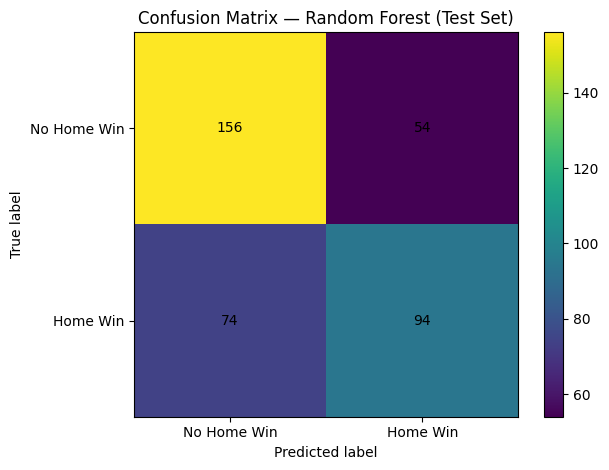

In [25]:
# ==============================
# 7. Random Forest: Train & Evaluate
# ==============================
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight='balanced'  # handles potential class imbalance
)

rf.fit(X_train, y_train)

y_val_pred = rf.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_acc:.3f}')
print('Validation Classification Report:', classification_report(y_val, y_val_pred))

y_test_pred = rf.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_acc:.3f}')
print('Test Classification Report:', classification_report(y_test, y_test_pred))

# Confusion matrix on the held-out test split.
cm = confusion_matrix(y_test, y_test_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix — Random Forest (Test Set)')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No Home Win', 'Home Win'])
plt.yticks(tick_marks, ['No Home Win', 'Home Win'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment='center',
                 verticalalignment='center')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()



## Optional: Hyperparameter Tuning

If you want to squeeze out a bit more performance, use GridSearchCV.
Note: This can take a few minutes depending on your environment.


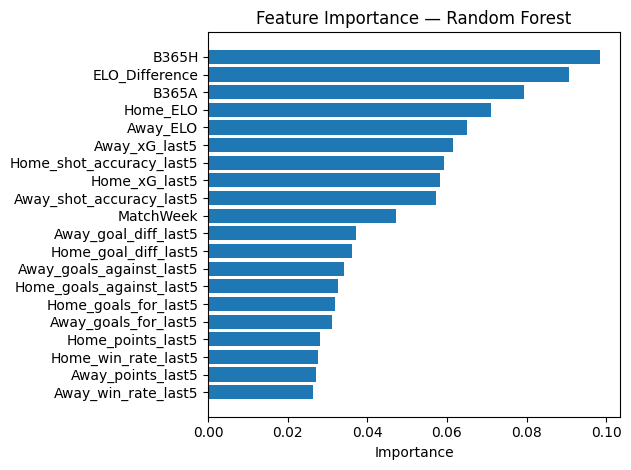

,feature,importance
0,B365H,0.098568
1,ELO_Difference,0.090631
2,B365A,0.079248
3,Home_ELO,0.071084
4,Away_ELO,0.065157
5,Away_xG_last5,0.061623
6,Home_shot_accuracy_last5,0.059135
7,Home_xG_last5,0.058297
8,Away_shot_accuracy_last5,0.057229
9,MatchWeek,0.047173


In [26]:
# ==============================
# 8. Feature Importance
# ==============================
importances = rf.feature_importances_
idx = np.argsort(importances)
feature_names = X_train.columns

plt.figure()
plt.barh(range(len(idx)), importances[idx])
plt.yticks(range(len(idx)), [feature_names[i] for i in idx])
plt.title('Feature Importance — Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Also show a tabular view.
fi_table = (
    pd.DataFrame({'feature': feature_names, 'importance': importances})
      .sort_values('importance', ascending=False)
      .reset_index(drop=True)
)
fi_table



## Interpretation Notes (for your report)

- **Accuracy** around ~0.70–0.75 is typical when using Elo/xG as predictors.
- **Top feature(s)** usually include `ELO_Difference` and `xG_Difference`, indicating that relative team strength and expected performance correlate strongly with home-win outcomes.
- Betting odds, when included, often add moderate incremental signal (markets embed a lot of prior information).

You can copy these insights into Section **4.4 Pre‑Match Factors vs Match Outcomes Analysis** of your report.


In [28]:
# ==============================
# 9. (Optional) Hyperparameter Tuning
# ==============================
# Uncomment to search for better parameters on the training split.
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 8, 12, 20],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train, y_train)
print('Best Params:', grid.best_params_)
print('Best CV Accuracy:', grid.best_score_)
best_model = grid.best_estimator_
val_accuracy = accuracy_score(y_val, best_model.predict(X_val))
test_accuracy = accuracy_score(y_test, best_model.predict(X_test))
print(f'Tuned Validation Accuracy: {val_accuracy:.3f}')
print(f'Tuned Test Accuracy: {test_accuracy:.3f}')


Best Params: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 300}
Best CV Accuracy: 0.6773802071321099
Tuned Validation Accuracy: 0.674
Tuned Test Accuracy: 0.693
